In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder

from keras.models import Sequential
from keras.layers import LSTM, Dense , Dropout
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.models import save_model, load_model


from gaft import GAEngine
from gaft.components import BinaryIndividual, Population
from gaft.operators import RouletteWheelSelection, UniformCrossover, FlipBitMutation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,Callback


In [2]:
df = pd.read_csv('Tasks_DataSet.csv')

# Extract features and target
X = df.drop(columns=['DataCenterID'])
y = df['DataCenterID']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print(df.columns)


Index(['TaskID', 'StartTime', 'TaskFileSize', 'TaskOutputFileSize',
       'TaskFileLength', 'DataCenterID'],
      dtype='object')


In [3]:

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

In [10]:
# Reshape data for LSTM input (assuming a time series sequence length of 1)
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val_lstm = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

#this params values from GA algorithm
model = Sequential()
model.add(LSTM(units=int(54), input_shape=(1, X_train.shape[1]), return_sequences=True))
model.add(LSTM(units=int(62)))
model.add(Dropout(0.08203125))
model.add(Dense(units=len(df['DataCenterID'].unique()), activation='softmax'))
model.compile(optimizer=Adam(learning_rate=0.014921875000000001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='accuracy', patience=10, restore_best_weights=True)
history=model.fit(X_train_lstm, y_train, epochs=94, batch_size=18, validation_data=(X_val_lstm, y_val), callbacks=[early_stopping])


Epoch 1/94
40/40 [==============================] - 5s 33ms/step - loss: 1.1082 - accuracy: 0.3194 - val_loss: 1.0986 - val_accuracy: 0.3611
Epoch 2/94
40/40 [==============================] - 0s 6ms/step - loss: 1.0986 - accuracy: 0.3514 - val_loss: 1.0988 - val_accuracy: 0.3833
Epoch 3/94
40/40 [==============================] - 0s 6ms/step - loss: 1.0970 - accuracy: 0.3444 - val_loss: 1.1024 - val_accuracy: 0.3611
Epoch 4/94
40/40 [==============================] - 0s 6ms/step - loss: 1.0965 - accuracy: 0.3458 - val_loss: 1.0948 - val_accuracy: 0.3944
Epoch 5/94
40/40 [==============================] - 0s 6ms/step - loss: 1.0953 - accuracy: 0.3625 - val_loss: 1.0972 - val_accuracy: 0.3500
Epoch 6/94
40/40 [==============================] - 0s 5ms/step - loss: 1.0912 - accuracy: 0.3681 - val_loss: 1.1022 - val_accuracy: 0.3444
Epoch 7/94
40/40 [==============================] - 0s 5ms/step - loss: 1.0894 - accuracy: 0.3597 - val_loss: 1.1301 - val_accuracy: 0.3611
Epoch 8/94
40/40 [=

In [11]:

# Assuming you have your X_test and y_test prepared similarly to X_train and y_train
X_test_lstm = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_lstm, y_val)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy*100:.2f}%')

# Make predictions on the test set
y_pred = model.predict(X_test_lstm)
# Convert the predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)


6/6 [==============================] - 1s 5ms/step - loss: 3.3432 - accuracy: 0.4278
Test Loss: 3.3432
Test Accuracy: 42.78%
6/6 [==============================] - 1s 3ms/step



Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.50      0.47        66
           1       0.50      0.38      0.43        56
           2       0.36      0.40      0.38        58

    accuracy                           0.43       180
   macro avg       0.44      0.42      0.43       180
weighted avg       0.43      0.43      0.43       180



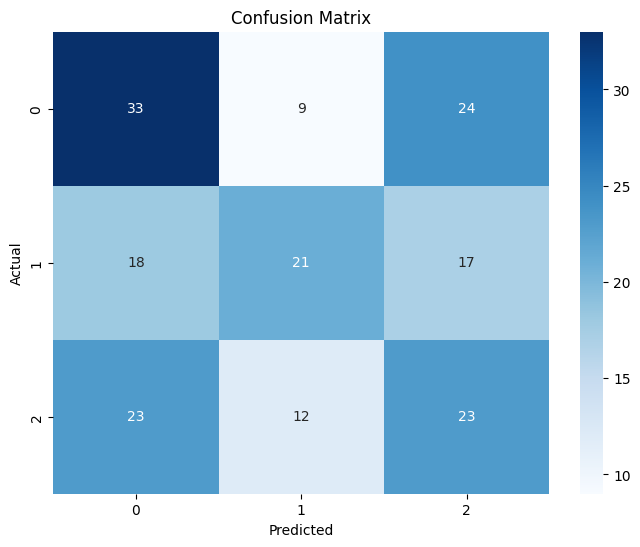

In [12]:
print("\nClassification Report:")
print(classification_report(y_val, y_pred_classes))

# Create a confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)

# Create a colorful confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



In [14]:
# model.save('lstm89.keras')


In [13]:


def predict_datacenter_id(requested_array,model_name):
    data_dict = {
        "TaskID": requested_array[0],
        "StartTime": requested_array[1],
        "TaskFileSize": requested_array[2],
        "TaskOutputFileSize": requested_array[3],
        "TaskFileLength": requested_array[4],

    }
    input_data = np.array([[
        data_dict["TaskID"],
        data_dict["StartTime"],
        data_dict["TaskFileSize"],
        data_dict["TaskOutputFileSize"],
        data_dict["TaskFileLength"]]])
    # Load the saved model
    loaded_model = load_model(model_name)
    # Reshape the input data to match the LSTM input shape
    input_data_lstm = input_data.reshape(input_data.shape[0], 1, input_data.shape[1])
    # Make predictions using the loaded model
    predicted_probabilities = loaded_model.predict(input_data_lstm)
    predicted_class = np.argmax(predicted_probabilities, axis=1)
    predicted_DC=predicted_class[0]
    return predicted_DC
requested_array = [0.1, 55, 0, 0, 55]
predicted_datacenter_id = predict_datacenter_id(requested_array,"lstm89.keras")
print(f"Predicted DataCenterID: {predicted_datacenter_id}")


1/1 [==============================] - 1s 1s/step
Predicted DataCenterID: 1


In [9]:
# Define the LSTM model
def create_and_train_model(units1, units2, dropout_rate, learning_rate, epochs, batch_size):
    print("\n\nNew generation training start. Parameters:")
    print(f"Units1: {units1}, Units2: {units2}, Dropout Rate: {dropout_rate}, Learning Rate: {learning_rate}, Epochs: {epochs}, Batch Size: {batch_size}\n")


    model = Sequential()
    model.add(LSTM(units=int(units1), input_shape=(1, X_train.shape[1]), return_sequences=True))
    model.add(LSTM(units=int(units2)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=len(df['DataCenterID'].unique()), activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    early_stopping = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
    history = model.fit(X_train_lstm, y_train, epochs=int(epochs), batch_size=int(batch_size), validation_data=(X_val_lstm, y_val), callbacks=[early_stopping])

    # Return the validation accuracy as the fitness
    return history.history['accuracy'][-1]

# Define individual
indv_template = BinaryIndividual(ranges=[(10, 100), (10, 100), (0.0, 1.0), (0.001, 0.1), (10, 100), (10, 100)])

# Create population
population = Population(indv_template=indv_template, size=50).init()

# Define Genetic Algorithm operators
selection = RouletteWheelSelection()
crossover = UniformCrossover(pc=0.8, pe=0.5)
mutation = FlipBitMutation(pm=0.1)

# Create Genetic Algorithm engine
engine = GAEngine(population=population, selection=selection, crossover=crossover, mutation=mutation)

# Define and register fitness function
@engine.fitness_register
def fitness(indv):
    # Decode GA individual to LSTM parameters
    units1, units2, dropout_rate, learning_rate, epochs, batch_size = indv.solution

    # Create and train LSTM model
    val_accuracy = create_and_train_model(units1, units2, dropout_rate, learning_rate, epochs, batch_size)
    
    return val_accuracy

# Run the Genetic Algorithm
engine.run(ng=50)




New generation training start. Parameters:
Units1: 64.832763671875, Units2: 69.81369018554688, Dropout Rate: 0.265625, Learning Rate: 0.005640625000000001, Epochs: 52.8521728515625, Batch Size: 93.51394653320312

Epoch 1/52
8/8 [==============================] - 6s 170ms/step - loss: 1.0992 - accuracy: 0.3417 - val_loss: 1.0992 - val_accuracy: 0.3333
Epoch 2/52
8/8 [==============================] - 0s 12ms/step - loss: 1.0951 - accuracy: 0.3694 - val_loss: 1.1061 - val_accuracy: 0.3500
Epoch 3/52
8/8 [==============================] - 0s 12ms/step - loss: 1.0931 - accuracy: 0.3583 - val_loss: 1.1099 - val_accuracy: 0.3389
Epoch 4/52
8/8 [==============================] - 0s 11ms/step - loss: 1.0927 - accuracy: 0.3667 - val_loss: 1.1125 - val_accuracy: 0.3444
Epoch 5/52
8/8 [==============================] - 0s 12ms/step - loss: 1.0907 - accuracy: 0.3806 - val_loss: 1.1061 - val_accuracy: 0.3778
Epoch 6/52
8/8 [==============================] - 0s 12ms/step - loss: 1.0890 - accuracy:

KeyboardInterrupt: 

In [1]:
! jupyter nbconvert --to script ga_lstm_v3.ipynb


Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "D:\python\python3115\Scripts\jupyter-nbconvert.EXE\__main__.py", line 4, in <module>
  File "D:\python\python3115\Lib\site-packages\nbconvert\nbconvertapp.py", line 186, in <module>
    class NbConvertApp(JupyterApp):
  File "D:\python\python3115\Lib\site-packages\nbconvert\nbconvertapp.py", line 245, in NbConvertApp
    Options include {get_export_names()}.
                     ^^^^^^^^^^^^^^^^^^
  File "D:\python\python3115\Lib\site-packages\nbconvert\exporters\base.py", line 151, in get_export_names
    e = get_exporter(exporter_name)(config=config)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\python\python3115\Lib\site-packages\nbconvert\exporters\base.py", line 110, in get_exporter
    exporter = items[0].load()
               ^^^^^^^^^^^^^^^
  File "D:\python\python3115\Lib\importlib\metadata\__init__.py", line 202, in load
    modu